In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
torch.__version__

'1.1.0'

In [2]:
if torch.cuda.is_available and torch.has_cudnn:
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/snli_train.tsv",sep="\t")
df_v = pd.read_csv("data/snli_val.tsv",sep="\t")

In [5]:
df_v.describe()

sentence1  \
count                                                1000   
unique                                                891   
top     A male bartender dressed in all black with his...   
freq                                                    2   

                   sentence2    label  
count                   1000     1000  
unique                   999        3  
top     People are outside .  neutral  
freq                       2      338

In [6]:
df_v.head()

sentence1  \
0  Three women on a stage , one wearing red shoes...   
1  Four people sit on a subway two read books , o...   
2  bicycles stationed while a group of people soc...   
3                  Man in overalls with two horses .   
4  Man observes a wavelength given off by an elec...   

                                           sentence2          label  
0          There are two women standing on the stage  contradiction  
1  Multiple people are on a subway together , wit...     entailment  
2     People get together near a stand of bicycles .     entailment  
3                  a man in overalls with two horses     entailment  
4  The man is examining what wavelength is given ...     entailment

In [7]:
first = df["sentence1"].values#[0:5000]
second = df["sentence2"].values#[0:5000]
labels = df["label"].values#[0:5000]

first_v = df_v["sentence1"].values#[0:500]
second_v = df_v["sentence2"].values#[0:500]
labels_v = df_v["label"].values#[0:500]

In [8]:
print(first[-1],second[-1],labels[-1])

Two gentlemen in tuxes play the keyboard and guitar . The two guys are in a band . neutral


In [9]:
print(len(set(labels)))

3


In [10]:
import string
punctuations = string.punctuation

In [11]:
labels[:10]

array(['neutral', 'entailment', 'neutral', 'contradiction',
       'contradiction', 'entailment', 'contradiction', 'neutral',
       'entailment', 'entailment'], dtype=object)

In [12]:
label_to_idx = {
    'entailment':0,
    'contradiction':1,
    'neutral':2
}

for i in range(len(labels)):
    labels[i] = label_to_idx[labels[i]]
    
for i in range(len(labels_v)):
    labels_v[i] = label_to_idx[labels_v[i]]

In [13]:
labels = labels.astype("int32")
labels_v = labels_v.astype("int32")

In [14]:
def tokenize(sent):
  #tokens = tokenizer(sent)
  return [word.lower() for word in sent.split(" ") if (word not in punctuations)]

In [15]:
tokenize("helldoifjsdoihfs . numpy")

['helldoifjsdoihfs', 'numpy']

In [16]:
labels

array([2, 0, 2, ..., 2, 1, 2], dtype=int32)

In [17]:
def tokenize_dataset(dataset1,dataset2):
    token_dataset1 = []
    token_dataset2 = []
    all_tokens = []
    
    for sample in dataset1:
        tokens = tokenize(sample)
        token_dataset1.append(tokens)
        all_tokens += tokens
        
    for sample in dataset2:
        tokens = tokenize(sample)
        token_dataset2.append(tokens)
        all_tokens += tokens

    return token_dataset1,token_dataset2, all_tokens


In [18]:
torch.LongTensor(labels);
torch.LongTensor(labels_v);

In [19]:
sent1_tokens,sent2_tokens,all_train_tokens = tokenize_dataset(first,second)
sent1_tokens_v,sent2_tokens_v,all_train_tokens_v = tokenize_dataset(first_v,second_v)

In [20]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

data = load_vectors("data/wiki-news-300d-1M.vec")

In [21]:
from collections import Counter

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)
token2id_v, id2token_v = build_vocab(all_train_tokens_v)

In [22]:
new_data = {}
emb_dim = 300
new_data["<pad>"] = (np.zeros((emb_dim,)),0)
new_data["<unk>"] = (np.random.normal(scale=0.6, size=(emb_dim, )),1)
count = 2
for word in data:
    new_data[word] = (np.fromiter(data[word],np.float64), count)
    count += 1
    if count > 200000+1:
        break
len(new_data)

200002

In [24]:
new_data


{'<pad>': (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [23]:
id2token

['<pad>',
 '<unk>',
 'a',
 'the',
 'in',
 'is',
 'man',
 'on',
 'and',
 'are',
 'of',
 'with',
 'woman',
 'two',
 'people',
 'to',
 'at',
 'wearing',
 'an',
 'his',
 'young',
 'men',
 'girl',
 'playing',
 'white',
 'boy',
 'shirt',
 'while',
 'black',
 'dog',
 'sitting',
 'blue',
 'standing',
 'her',
 'red',
 'group',
 'for',
 'outside',
 'down',
 'street',
 'walking',
 'person',
 'front',
 'women',
 'holding',
 'child',
 'one',
 'by',
 'three',
 'there',
 'water',
 'their',
 'up',
 'children',
 'looking',
 'as',
 'some',
 'green',
 'from',
 'little',
 'other',
 'large',
 'has',
 'running',
 'yellow',
 'riding',
 'through',
 'out',
 'ball',
 'hat',
 'beach',
 'building',
 'brown',
 'into',
 'next',
 'near',
 'dressed',
 'small',
 'over',
 'another',
 'girls',
 'dogs',
 'around',
 'crowd',
 'bike',
 "'s",
 'jacket',
 'sits',
 'stands',
 'field',
 'it',
 'sidewalk',
 'jumping',
 'table',
 'working',
 'that',
 'behind',
 'background',
 'orange',
 'park',
 'pink',
 'boys',
 'lady',
 'pictu

In [ ]:
sent1_tokens

In [25]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

sent1_indices = token2index_dataset(sent1_tokens)
sent2_indices = token2index_dataset(sent2_tokens)
sent1_indices_v = token2index_dataset(sent1_tokens_v)
sent2_indices_v = token2index_dataset(sent2_tokens_v)
#test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("sent1 dataset size is {}".format(len(sent1_indices)))
print ("sent2 dataset size is {}".format(len(sent2_indices)))
print ("Val dataset size is {}".format(len(sent1_indices_v)))
#print ("Test dataset size is {}".format(len(test_data_indices)))

sent1 dataset size is 100000
sent2 dataset size is 100000
Val dataset size is 1000


In [ ]:
print([id2token[i] for i in sent1_indices[5]])

In [ ]:
sent1_indices[5]

In [ ]:
import random
rand_training_example = random.randint(0, len(first) - 1)
print (sent1_indices[rand_training_example])
print(sent1_tokens[rand_training_example])
print (sent2_indices[rand_training_example])
print(sent2_tokens[rand_training_example])
print(labels[rand_training_example])

In [ ]:
max(max([len(s) for s in sent1_tokens]),max([len(s) for s in sent2_tokens]))

In [ ]:
id2token[-1]

In [26]:
def build_word_embedding(id2token,new_data,emd_dim=300):
    matrix_len = len(id2token)
    weights_matrix = np.zeros((matrix_len, emb_dim))
    trainable_id = []
    
    for i,v in enumerate(id2token):
        try:
            cur_embed = new_data[v][0]
            weights_matrix[i] = cur_embed
        except KeyError:
            weights_matrix[i] = new_data["<unk>"][0]
            trainable_id.append(i)
            
    return weights_matrix,trainable_id

In [27]:
weights_matrix,trainable_id = build_word_embedding(id2token,new_data)

In [28]:
weights_matrix = torch.from_numpy(weights_matrix).float()

In [29]:
weights_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0375,  0.0768,  0.0207,  ..., -0.0352,  1.4497,  1.0253],
        [ 0.0047,  0.0223, -0.0087,  ...,  0.1479,  0.1324, -0.0318],
        ...,
        [ 0.0735,  0.0856,  0.1239,  ..., -0.0355,  0.1138, -0.0028],
        [ 0.0683, -0.0117, -0.1440,  ...,  0.1539,  0.0363, -0.0243],
        [ 0.0375,  0.0768,  0.0207,  ..., -0.0352,  1.4497,  1.0253]])

In [30]:
len(trainable_id)

3992

In [ ]:
m = (1 == trainable_id)
m

In [31]:
MAX_SENTENCE_LENGTH = 50


In [32]:
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

sent1_indices = token2index_dataset(sent1_tokens)
sent2_indices = token2index_dataset(sent2_tokens)
sent1_indices_v = token2index_dataset(sent1_tokens_v)
sent2_indices_v = token2index_dataset(sent2_tokens_v)

In [33]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list1,data_list2, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.target_list = target_list
        assert (len(self.data_list1) == len(self.data_list2) == len(self.target_list))

    def __len__(self):
        return len(self.data_list1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx1 = self.data_list1[key][:MAX_SENTENCE_LENGTH]
        token_idx2 = self.data_list2[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx1,len(token_idx1),token_idx2,len(token_idx2),label]


In [34]:
train_dataset = SNLIDataset(sent1_indices,sent2_indices,labels)
val_dataset = SNLIDataset(sent1_indices_v,sent2_indices_v,labels_v)

In [35]:
#print(train_dataset[0])
s = val_dataset[99][0]
t = val_dataset[99][2]
#print(s)
print([id2token[i] for i in s])
print([id2token[i] for i in t])
print(val_dataset[99][-1])
#print([id2token[i] for i in range(len(train_dataset[0])])

['the', 'boy', 'wearing', 'the', 'blue', 'hooded', 'top', 'is', 'holding', 'a', 'baby', 'goat', 'in', 'his', 'arms']
['a', 'boy', 'ran', 'from', 'a', 'goat']
1


In [36]:
print("x {}{};\ny {}".format(val_dataset[99][0], val_dataset[99][2],val_dataset[99][-1]))

x [3, 25, 17, 3, 31, 1164, 117, 5, 44, 2, 144, 2197, 4, 19, 329][2, 25, 2058, 58, 2, 2197];
y 1


In [37]:
def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list1 = []
    data_list2 = []
    label_list = []
    length_list1 = []
    length_list2 = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[-1])
        length_list1.append(datum[1])
    # padding
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list1.append(padded_vec1)
        
    for datum in batch:
        length_list2.append(datum[3])
    # padding
    for datum in batch:
        padded_vec2 = np.pad(np.array(datum[2]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data_list2.append(padded_vec2)
    return [torch.from_numpy(np.array(data_list1)), torch.LongTensor(length_list1),torch.from_numpy(np.array(data_list2)), torch.LongTensor(length_list2), torch.LongTensor(label_list)]

In [38]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

In [39]:
for i, (data1, lengths1,data2, lengths2, labels) in enumerate(val_loader):
    print(data1.shape)
    #print(lengths1[1].item())
    ##print(data2[1])
    #print(lengths2[1].item())
    #print(labels[1].item())
    break

torch.Size([32, 50])


In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, weight_matrix):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
#         self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.embed = nn.Embedding.from_pretrained(weight_matrix,freeze=False)
        #self.concat = 
        self.linear1 = nn.Linear(emb_dim,256)
        self.linear2 = nn.Linear(256,64)
        self.linear3 = nn.Linear(64,3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,data1,length1,data2,length2):
        # emb                    x
        prem_embed = self.embed(data1) # 64xlen
        m = (data1 == 1)
        #print(m.shape)
        m = m.unsqueeze(2).repeat(1, 1, emb_dim).type(torch.FloatTensor).to(device)
        prem_embed = m * prem_embed + (1-m) * prem_embed.clone().detach()
        prem_embed = torch.sum(prem_embed, dim=1) #64
        prem_embed /= length1.view(length1.size()[0],1).expand_as(prem_embed).float()
        #print(prem_embed.shape)
        #print(m.shape)
        #prem_embed = m * prem_embed + (1-m) * prem_embed.clone().detach()
        
        hypo_embed = self.embed(data2)
        m = (data2 == 1)
        m = m.unsqueeze(2).repeat(1, 1, emb_dim).type(torch.FloatTensor).to(device)
        hypo_embed = m * hypo_embed + (1-m) * hypo_embed.clone().detach()
        hypo_embed = torch.sum(hypo_embed, dim=1)
        hypo_embed /= length2.view(length2.size()[0],1).expand_as(hypo_embed).float()
        
        
        out = prem_embed * hypo_embed # 300,1
        
        out = self.linear1(out).float()
        out = self.relu(out).float()
        #out = self.dropout(out)
        out = self.linear2(out).float()
        out = self.relu(out).float()
        #out = self.dropout(out)
        out = self.linear3(out.float())
        
        return out

In [65]:
weights_matrix.shape

torch.Size([20002, 300])

In [67]:
# emb_dim = 128
# model = BagOfWords(len(id2token), emb_dim)

model = BagOfWords(weights_matrix)

In [68]:
model.embed.weight.shape

torch.Size([20002, 300])

In [69]:
criterion = torch.nn.CrossEntropyLoss()  

learning_rate = 5e-4
weight_decay = 1e-6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0)

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

6094299


In [71]:
num_epochs = 12 # number epoch to train
val_acc_graph = []
train_loss_graph = []
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    sample = []
    for data1, length1, data2, length2, labels in loader:
        data_batch1, length_batch1, data_batch2, length_batch2, label_batch = data1, length1, data2, length2, labels
        outputs = F.softmax(model(data_batch1, length_batch1,data_batch2,length_batch2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        temp = predicted
        sample.append([temp,labels])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total), sample

for epoch in range(num_epochs):
    for i, (data1, length1, data2, length2, labels) in enumerate(train_loader):
        model.train()
        data_batch1, length_batch1,data_batch2, length_batch2, label_batch = data1, length1, data2, length2, labels
        optimizer.zero_grad()
        outputs = model(data_batch1, length_batch1,data_batch2,length_batch2)
        loss = criterion(outputs, label_batch)
        #print(loss)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            #pass
            # validate
            val_acc = test_model(val_loader, model)[0]
            val_acc_graph.append(val_acc)
            train_loss_graph.append(loss.item())
            print(loss.item())
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
               epoch+1, num_epochs, i+1, len(train_loader), val_acc))


1.1024081707000732
Epoch: [1/12], Step: [101/3125], Validation Acc: 33.1
1.0925394296646118
Epoch: [1/12], Step: [201/3125], Validation Acc: 33.1
1.1018882989883423
Epoch: [1/12], Step: [301/3125], Validation Acc: 33.4
1.0867524147033691
Epoch: [1/12], Step: [401/3125], Validation Acc: 41.2
1.0951746702194214
Epoch: [1/12], Step: [501/3125], Validation Acc: 42.7
1.0249223709106445
Epoch: [1/12], Step: [601/3125], Validation Acc: 40.4
1.0944676399230957
Epoch: [1/12], Step: [701/3125], Validation Acc: 43.4
1.0523089170455933
Epoch: [1/12], Step: [801/3125], Validation Acc: 42.0
1.0396366119384766
Epoch: [1/12], Step: [901/3125], Validation Acc: 43.6
1.0069459676742554
Epoch: [1/12], Step: [1001/3125], Validation Acc: 44.4
1.0362484455108643
Epoch: [1/12], Step: [1101/3125], Validation Acc: 44.2
1.0055853128433228
Epoch: [1/12], Step: [1201/3125], Validation Acc: 42.7
0.9603237509727478
Epoch: [1/12], Step: [1301/3125], Validation Acc: 41.7
0.9722390174865723
Epoch: [1/12], Step: [1401/3

0.9950206875801086
Epoch: [4/12], Step: [2001/3125], Validation Acc: 52.9
0.9353926777839661
Epoch: [4/12], Step: [2101/3125], Validation Acc: 53.7
0.9508524537086487
Epoch: [4/12], Step: [2201/3125], Validation Acc: 55.7
0.9837785959243774
Epoch: [4/12], Step: [2301/3125], Validation Acc: 55.0
0.8609886765480042
Epoch: [4/12], Step: [2401/3125], Validation Acc: 53.6
0.9610635638237
Epoch: [4/12], Step: [2501/3125], Validation Acc: 54.9
0.880845308303833
Epoch: [4/12], Step: [2601/3125], Validation Acc: 53.9
0.9502358436584473
Epoch: [4/12], Step: [2701/3125], Validation Acc: 55.3
1.0739432573318481
Epoch: [4/12], Step: [2801/3125], Validation Acc: 54.3
0.7812498211860657
Epoch: [4/12], Step: [2901/3125], Validation Acc: 55.4
0.8716703057289124
Epoch: [4/12], Step: [3001/3125], Validation Acc: 55.3
1.0068755149841309
Epoch: [4/12], Step: [3101/3125], Validation Acc: 55.0
1.0012469291687012
Epoch: [5/12], Step: [101/3125], Validation Acc: 54.4
0.9699196219444275
Epoch: [5/12], Step: [20

0.8771553635597229
Epoch: [8/12], Step: [801/3125], Validation Acc: 55.5
0.7817854881286621
Epoch: [8/12], Step: [901/3125], Validation Acc: 55.2
0.6698991656303406
Epoch: [8/12], Step: [1001/3125], Validation Acc: 55.9
0.9074326157569885
Epoch: [8/12], Step: [1101/3125], Validation Acc: 56.8
1.137140154838562
Epoch: [8/12], Step: [1201/3125], Validation Acc: 56.9
0.8976379036903381
Epoch: [8/12], Step: [1301/3125], Validation Acc: 56.3
0.864362359046936
Epoch: [8/12], Step: [1401/3125], Validation Acc: 55.2
0.7953739166259766
Epoch: [8/12], Step: [1501/3125], Validation Acc: 57.1
0.8905801177024841
Epoch: [8/12], Step: [1601/3125], Validation Acc: 54.7
0.831515371799469
Epoch: [8/12], Step: [1701/3125], Validation Acc: 56.3
0.795487642288208
Epoch: [8/12], Step: [1801/3125], Validation Acc: 57.2
0.8262921571731567
Epoch: [8/12], Step: [1901/3125], Validation Acc: 54.2
1.032415747642517
Epoch: [8/12], Step: [2001/3125], Validation Acc: 56.3
0.7229894995689392
Epoch: [8/12], Step: [2101

1.0009453296661377
Epoch: [11/12], Step: [2601/3125], Validation Acc: 56.8
0.801281750202179
Epoch: [11/12], Step: [2701/3125], Validation Acc: 57.8
0.7433723211288452
Epoch: [11/12], Step: [2801/3125], Validation Acc: 56.0
0.8460459113121033
Epoch: [11/12], Step: [2901/3125], Validation Acc: 56.1
0.9559414982795715
Epoch: [11/12], Step: [3001/3125], Validation Acc: 56.2
0.9631727337837219
Epoch: [11/12], Step: [3101/3125], Validation Acc: 56.6
0.778458833694458
Epoch: [12/12], Step: [101/3125], Validation Acc: 57.1
0.8580614328384399
Epoch: [12/12], Step: [201/3125], Validation Acc: 57.6
0.8679677844047546
Epoch: [12/12], Step: [301/3125], Validation Acc: 57.5
0.9554107189178467
Epoch: [12/12], Step: [401/3125], Validation Acc: 56.2
0.7320119142532349
Epoch: [12/12], Step: [501/3125], Validation Acc: 57.3
0.7434991598129272
Epoch: [12/12], Step: [601/3125], Validation Acc: 58.4
0.9657004475593567
Epoch: [12/12], Step: [701/3125], Validation Acc: 55.6
0.8225868940353394
Epoch: [12/12],

In [72]:
print ("After training for {} epochs".format(num_epochs))
print ("Train Acc {}".format(test_model(train_loader, model)[0]))
print ("Val Acc {}".format(test_model(val_loader, model)[0]))
print("Number of parameters {}".format(count_parameters(model)))

After training for 12 epochs
Train Acc 58.019
Val Acc 57.9
Number of parameters 6094299


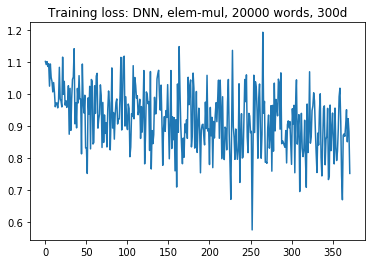

In [73]:
import matplotlib.pyplot as plt
x = np.arange(len(train_loss_graph))
plt.plot(x, train_loss_graph)
plt.title("Training loss: DNN, elem-mul, 20000 words, 300d")
plt.savefig("ft_train_loss",format = "png")

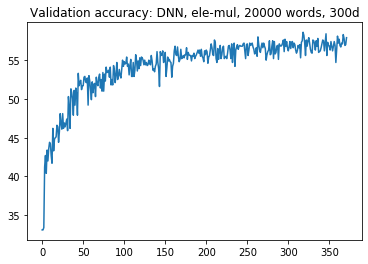

In [74]:
x = np.arange(len(val_acc_graph))
plt.plot(x, val_acc_graph)
plt.title("Validation accuracy: DNN, ele-mul, 20000 words, 300d")
plt.savefig("ft_val_acc",format = "png")

In [75]:
def saveList(myList,filename):
    # the filename should mention the extension 'npy'
    np.save(filename,myList)
    print("Saved successfully!")
train_loss_graph = np.asarray(train_loss_graph, dtype=np.float32)
val_acc_graph = np.asarray(val_acc_graph, dtype=np.float32)
saveList(train_loss_graph,"figures/pretrain_loss.npy")
saveList(val_acc_graph,"figures/pretrain_valacc.npy")

Saved successfully!
Saved successfully!


In [76]:
torch.save(model.state_dict(), "DNN_elemut_SNLI_10000_128.pt")